In [261]:
import os
import sys
from tweepy import API
from tweepy import OAuthHandler
from tweepy import Cursor
import json
from collections import Counter
import math
import time
import pandas as pd
import csv
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [251]:
def getTwitterOAuth():
    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_token_secret = ''
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token,access_token_secret)
    return auth

def TwitterClient():
    auth = getTwitterOAuth()
    client = API(auth)
    return client

#global variables
MAX_FRIENDS = 15000
max_pages = math.ceil(MAX_FRIENDS/5000)
        
def makeDirectory():
    client = TwitterClient()
    #dirname = "users/{}".format(user)
    dirname = "users"
    
    try:
        os.makedirs(dirname, mode =0o755, exist_ok=True)
    except OSError:
        print("Directory {} already exist".format(dirname))
    except Exception as e:
        print( "Error while creating directory {}".format(dirname))
        print(e)
        sys.exit(1)

        
        
        
        
def getHashtags(tweet):
    entities = tweet.get('entities',{})
    hashtags = entities.get('hashtags',[])
    return [tag['text'].lower() for tag in hashtags]

def tags(user='AvokaAyebilla'):
    hashtags = Counter()
    taglist = []
    fname = "users/influencers/{}_timeline.jsonl".format(user)
    with open(fname, 'r') as f:
        for line in f:
            tweet = json.loads(line)
            tags_in_tweet = getHashtags(tweet)
            hashtags.update(tags_in_tweet)
        return {user:hashtags.most_common(5)} #gets the five most used hashtag

#Gets a user's timeline, followers count, likes, retweets, tweet_count
def getUserTweets(user='AvokaAyebilla'):
    #makeDirectory()
    ufollowers = 0
    uretweets = 0
    ulikes = 0
    utweets = 0
    ufriends = 0
    utweet = 0
    umentions = []
    fname = "users/influencers/{}_timeline.jsonl".format(user)
    if not os.path.exists(os.path.join('users', "/influencers/{}_timeline.jsonl".format(user))):
        client = TwitterClient()
        with open(fname, 'w') as f:
            pages = Cursor(client.user_timeline, screen_name=user,count=200).pages(max_pages)
            for apage in pages:
                for twet in apage:
                    ufollowers = twet.user.followers_count
                    ufriends =   twet.user.friends_count
                    utweet =     twet.user.statuses_count
                    break
                break

            for page in pages:
                for status in page:
                    f.write(json.dumps(status._json) + "\n")
                    status = status._json
                    uretweets = uretweets + status['retweet_count']
                    ulikes =  ulikes + status['favorite_count']
                    mentions = ", ".join([mention['screen_name'] for mention in status['entities']['user_mentions']])
                    umentions.append(mentions)
                    
                if len(page) == 800:
                    time.sleep(60) 
    else:
        
        timeline = "users/influencers/{}_timeline.jsonl".format(user)
        with open(timeline, 'r') as f:
            for line in f:
                twet = json.loads(line)
                ufollowers =twet['user']['followers_count']
                ufriends =  twet['user']['friends_count']
                utweet = twet['user']['statuses_count']
                break
            
            for line in f:
                twet = json.loads(line)
                mentions = ", ".join([mention['screen_name'] for mention in twet['entities']['user_mentions']])
                umentions.append(mentions)
                uretweets = uretweets + twet['retweet_count']
                ulikes =  ulikes + twet['favorite_count']
                    
    return {user:[ufollowers, uretweets,ulikes,utweet,ufriends,len(umentions),uretweets+ulikes,ufollowers-ufriends,len(umentions)]}

        
  #reads saved list of users from csv file on disk into python list
def worker():
    uList = []
    tagList = []
    
    #Open one data file at a time to generate stats for the two groups
    with open('African_influencers.csv', 'rt') as f:
    #with open('Top_gov_officials.csv', 'rt') as f:
        f.readline()
        csv_reader = csv.reader(f)
        for line in csv_reader:
            try:
                uList.append(getUserTweets(line[0]))
                #tagList.append(tags(line[0]))
            except Exception as e:
                print( "Error while getting timeline for  {}".format(line[0]))
                print(e)
    return uList,tagList


#converts the list of dictionaries into a dictionary
def ConvertToDict(ListDictLists):
    NewDict = {}  
    for listItem in ListDictLists:
        for key, value in listItem.items(): 
            if key in list(NewDict):  # if the key already exists, append to new
                for entry in value:
                    NewDict[key].append(entry)
            else:  
                NewDict[key] = value
    return NewDict

#returns the keys of the dictionary as a list
def get_dictkeys(listdic):
    return list (listdic.keys())

#returns the values of the dictionary as a list
def get_dictvals(listdic):
     return list(listdic.values())
    
def dataframe():
    uList, tagList= worker()
    dictt = ConvertToDict(uList)
    data =  get_dictvals(dictt)
    df = pd.DataFrame(data, columns = ["followers", "retweets","likes","tweets","friends","mentions","popularity_score","reach_score","relevance_score"])
    coll = get_dictkeys(dictt)
    df.insert(0,'Influencers',coll)
    print(tagList)
    return df
dff = dataframe()
df_influ = dataframe()
#dff



Error while getting timeline for  andBeyondSafari
Twitter error response: status code = 404
Error while getting timeline for  hurricanevaness
Twitter error response: status code = 404
Error while getting timeline for  BBCKarenAllen
Twitter error response: status code = 404
Error while getting timeline for  drewfhinshaw
Twitter error response: status code = 404
Error while getting timeline for  Afrinnovator
Twitter error response: status code = 401
Error while getting timeline for  The_New_Age
Twitter error response: status code = 401
Error while getting timeline for  702JohnRobbie
Twitter error response: status code = 404
[]


In [230]:
plrtsort = dff.sort_values(by=['popularity_score'])

In [231]:
rchtsort = dff.sort_values(by=['reach_score'])

In [233]:
rlvtsort = dff.sort_values(by=['relevance_score'])

In [239]:
reach = rchtsort.tail(10)

In [240]:
relevant = rlvtsort.tail(10)

In [241]:
popular = plrtsort.tail(10)

In [317]:
dff 

,Influencers,followers,retweets,likes,tweets,friends,mentions,popularity_score,reach_score,relevance_score
0,EswatiniGovern1,11330,3084,12218,1676,82,400,15302,11248,400
1,MalawiGovt,39337,2929,6444,4030,26,400,9373,39311,400
2,hagegeingob,192567,16132,73313,1087,55,400,89445,192512,400
3,FinanceSC,127,0,0,125,224,0,0,-97,0
4,PresidencyZA,1600090,16707,33833,18882,14,400,50540,1600076,400
5,mohzambia,7176,518,571,838,95,400,1089,7081,400
6,edmnangagwa,546829,116637,420244,628,116,395,536881,546713,395
7,MinSantedj,2935,38025,1793,1065,127,395,39818,2808,395
8,hawelti,66324,21300,47239,4720,435,400,68539,65889,400
9,StateHouseKenya,1104467,21224,90645,9052,214,400,111869,1104253,400


In [249]:
reduce(np.intersect1d, [reach.Influencers, relevant.Influencers,popular.Influencers])

array(['PaulKagame'], dtype=object)

No handles with labels found to put in legend.


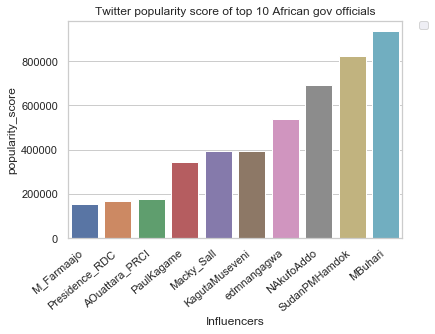

In [264]:
with sns.axes_style("whitegrid"):
    chart = sns.barplot(x="Influencers", y="popularity_score",  data=popular)
    chart.set_xticklabels(rotation=40, ha="right", labels= popular['Influencers'])
plt.title("Twitter popularity score of top 10 African gov officials")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0.)

No handles with labels found to put in legend.


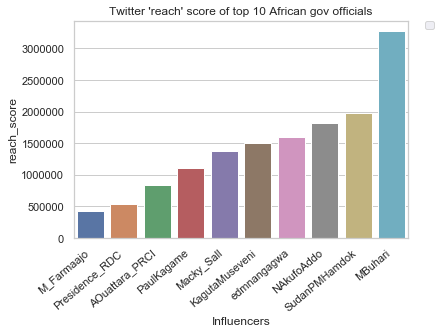

In [265]:
with sns.axes_style("whitegrid"):
    chart = sns.barplot(x="Influencers", y="reach_score",  data=reach)
    chart.set_xticklabels(rotation=40, ha="right", labels= popular['Influencers'])
plt.title("Twitter 'reach' score of top 10 African gov officials")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0.)

In [272]:
plrtsort_ = df_influ.sort_values(by=['popularity_score'])
rchtsort_ = df_influ.sort_values(by=['reach_score'])
rlvtsort_i = df_influ.sort_values(by=['relevance_score'])
reach_i = rchtsort.tail(10)
relevant_i = rlvtsort.tail(10)
popular_i = plrtsort.tail(10)




No handles with labels found to put in legend.


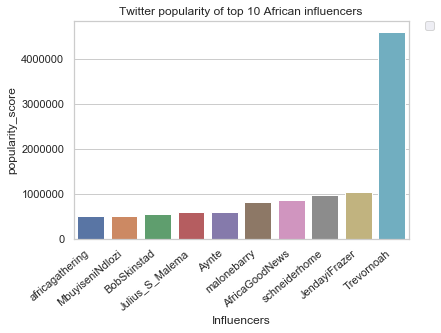

In [275]:
with sns.axes_style("whitegrid"):
    chart = sns.barplot(x="Influencers", y="popularity_score",  data=popular_i)
    chart.set_xticklabels(rotation=40, ha="right", labels= popular['Influencers'])
plt.title("Twitter popularity of top 10 African influencers")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0.)

In [309]:
popular_i = plrtsort.tail(5)
popular_g = popular.tail(5)
influs = popular_i['popularity_score']
govs = popular_g['popularity_score']
index = ['snail', 'pig', 'elephant',
         'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                   'lifespan': lifespan}, index=index)
ax = df.plot.bar(rot=0)


In [310]:
df_con = pd.concat([popular_g, popular_i], ignore_index=True)

No handles with labels found to put in legend.


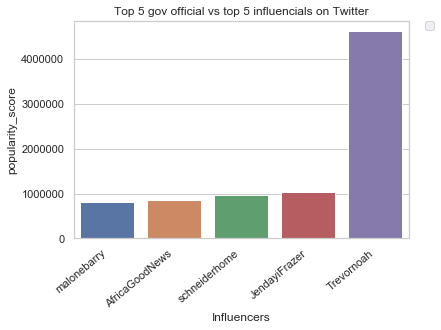

In [313]:
with sns.axes_style("whitegrid"):
    chart = sns.barplot(x="Influencers", y="popularity_score",  data=popular_i)
    chart2 = sns.barplot(x="Influencers", y="popularity_score",  data=popular_g)
    chart.set_xticklabels(rotation=40, ha="right", labels= popular_i['Influencers'])
    chart.set_xticklabels(rotation=40, ha="right", labels= popular_g['Influencers'])
plt.title("Top 5 gov official vs top 5 influencials on Twitter")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0.)

In [314]:
df_con

x = 

,Influencers,followers,retweets,likes,tweets,friends,mentions,popularity_score,reach_score,relevance_score
0,malonebarry,28535,803851,3768,35280,2988,399,807619,25547,399
1,AfricaGoodNews,50092,855942,21,11100,757,388,855963,49335,388
2,schneiderhome,26430,973812,4142,32731,1007,397,977954,25423,397
3,JendayiFrazer,29955,1043120,13,3118,480,398,1043133,29475,398
4,Trevornoah,10810225,2534533,2086604,11186,325,399,4621137,10809900,399
5,malonebarry,28535,803851,3768,35280,2988,399,807619,25547,399
6,AfricaGoodNews,50092,855942,21,11100,757,388,855963,49335,388
7,schneiderhome,26430,973812,4142,32731,1007,397,977954,25423,397
8,JendayiFrazer,29955,1043120,13,3118,480,398,1043133,29475,398
9,Trevornoah,10810225,2534533,2086604,11186,325,399,4621137,10809900,399
